In [ ]:
# default_exp data

# Data

> Visualize defects.

In [ ]:
# hide
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
# hide
from nbdev import show_doc

In [ ]:
# export
from steel_segmentation.core import *
from fastcore.foundation import *
from PIL import Image
from collections import defaultdict
from matplotlib import pyplot as plt
from fastcore.test import test_eq
from fastai.data.transforms import get_image_files
from fastai.vision.all import Image

import pandas as pd
import numpy as np

In [ ]:
# hide
only_imgs = ["0a1cade03.jpg", "bca4ae758.jpg", "988cf521f.jpg", "b6a257b28.jpg",
             "b2ad335bf.jpg", "72aaba8ad.jpg", "f383950e8.jpg"]
train = train[train["ImageId"].isin(only_imgs)].copy()
train_all = train_all[train_all["ImageId"].isin(only_imgs)].copy()
train_multi = train_multi[train_multi["ImageId"].isin(only_imgs)].copy()

## An example

From an `ImageId` we get the pixel coordinates or the mask for every defect. Here an example of steel image.

            ImageId  ClassId
6757  f383950e8.jpg        3
6758  f383950e8.jpg        4


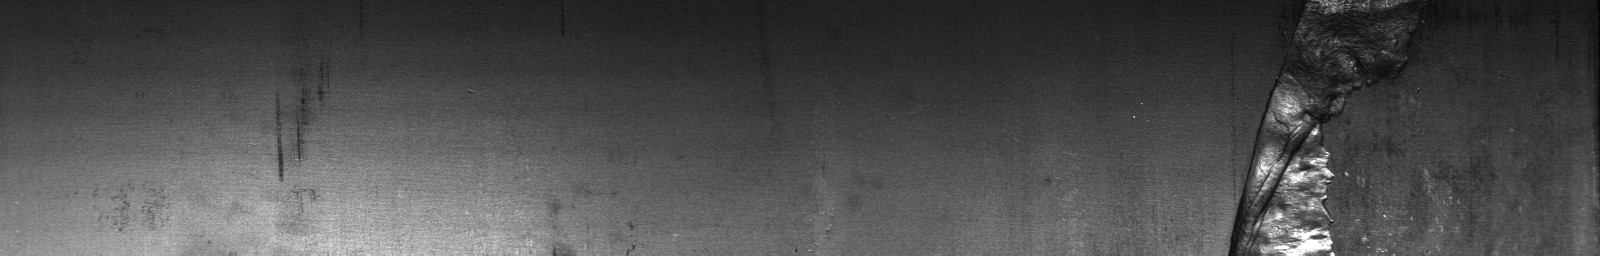

In [ ]:
img_id = "f383950e8.jpg"
tmp_df = train[train['ImageId'] == img_id]
img_path = train_path / img_id
im = Image.open(img_path)

print(tmp_df[["ImageId", "ClassId"]])
im

In [ ]:
height, width = im.shape
height, width

(256, 1600)

In [ ]:
assert height == 256
assert width == 1600

## Discovery defect functions

In [ ]:
# export
def defeat_position(img_id: str, class_id: int, df: pd.DataFrame = train):
    """
    Get coordinates of defects `(x, y)` given an ImageId and a ClassId 
    """
    # Select the image to mask
    # cond = df.ImageId_ClassId == f"{img_id}_{class_id}"
    cond = (df.ImageId == img_id) & (df.ClassId == class_id)
    train_s = df[cond]

    encoded_pixels = [int(i)
                      for i in train_s.EncodedPixels.values[0].split(" ")]

    pixcels = []
    pos_pixels = encoded_pixels[0:len(encoded_pixels):2]
    offs_pixels = encoded_pixels[1:len(encoded_pixels):2]

    for pos, offset in zip(pos_pixels, offs_pixels):
        pixcels.extend(list(range(pos, pos+offset)))

    pixcels = np.array(pixcels)
    x = pixcels // 256
    y = pixcels % 256

    return x, y

In [ ]:
x, y = defeat_position(img_id=img_id, class_id=4)
x.shape, y.shape

((36002,), (36002,))

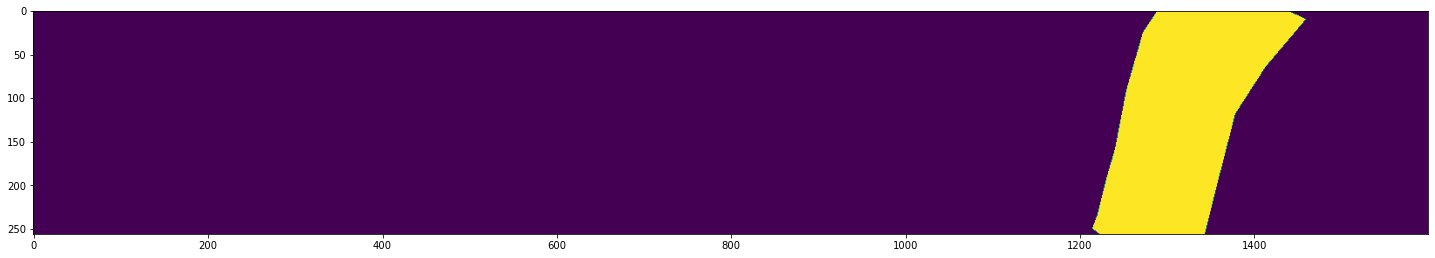

In [ ]:
im_array = np.zeros((256,1600))
im_array[y,x] = 255

plt.figure(figsize=(25, 5))
plt.imshow(im_array)
plt.show()

## Picking functions

In [ ]:
# export
def get_random_idx(n: int) -> np.ndarray:
    """
    Return a random sequence of size `n`.
    """
    rng = np.random.default_rng()
    return rng.permutation(n)

In [ ]:
get_random_idx(50)

array([47, 28,  9, 21, 12, 25, 10, 42, 35, 37, 45, 22, 33, 38, 15, 43, 17,
       26, 49,  0, 46, 24, 18, 14, 16, 36,  2, 27,  4, 29, 20,  6,  5, 19,
       40,  1, 39,  7, 31,  3, 44, 32, 11, 41, 30, 13, 34,  8, 48, 23])

In [ ]:
# export
def get_perm_imgs_path(train_pfiles: L, df: pd.DataFrame) -> L:
    """
    Return img Path list of selected df.
    """
    imgId_vals = df["ImageId"].drop_duplicates().values
    path_idx = train_pfiles.argwhere(lambda x: x.name in imgId_vals)
    sel_paths = train_pfiles[path_idx]
    idx = get_random_idx(len(sel_paths))
    return sel_paths[idx]

In [ ]:
get_perm_imgs_path(train_pfiles, train_all)[:5]

(#5) [Path('../data/train_images/6d5103080.jpg'),Path('../data/train_images/0ddbc9fb5.jpg'),Path('../data/train_images/cf5231a23.jpg'),Path('../data/train_images/43a450e62.jpg'),Path('../data/train_images/8b1fd00ed.jpg')]

## Show defects

In [ ]:
# export
def plot_defected_image(img_path: str, df: pd.DataFrame = train):
    """
    Plot image with segmented area
    """
    def color(x, y, classid):
        if classid == 4:
            im[y, x, 1] += 50
            im[y, x, 2] += 50
        else:
            im[y, x, classid-1] += 50

    def plot(im, imgid, classids):
        clip_im = np.clip(im, 0, 255)
        title = "ImageId: {} - ClassId: {}".format(
            imgid, " ".join(map(str, classids)))

        plt.figure(figsize=(25, 5))
        plt.imshow(clip_im)
        plt.xticks([])
        plt.yticks([])
        plt.title(title, fontsize=20)
        plt.show()

    im = np.array(Image.open(img_path))

    img_id = img_path.name
    df = df.loc[df["ImageId"] == img_id]

    classids = []
    for img in df.itertuples(index=False):
        classids.append(img.ClassId)
        classid = img.ClassId

        x, y = defeat_position(img_id, classid)

        color(x, y, classid)

    plot(im, img_id, classids)

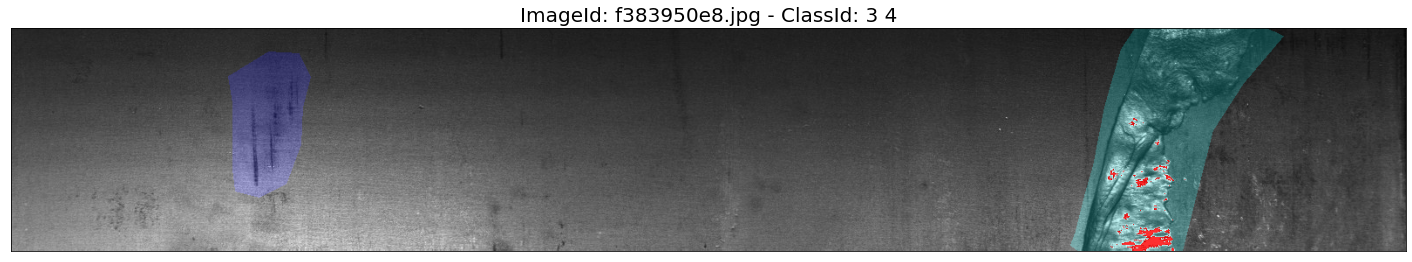

In [ ]:
plot_defected_image(img_path)

In [ ]:
# export
def show_defects(class_id=None, n=20, only_defects=True, multi_defects=False):
    """
    Plot multiple images. 
    Attributes: 
    `class_id`: [str or int] select a type of defect otherwise plot all kinds;
    `n`: select the number of images to plot;
    `only_defects` [bool, default True]: if False it shows even the no faulty images;
    `multi_defects` [bool, default False]: if True it shows imgs with multi defects.
    """
    df = train_multi

    cond_no_defects = df["ClassId_multi"] == '0'
    cond_multi_defects = df["ClassId_multi"].map(lambda x: len(x) > 1)
    cond_classId = df["ClassId_multi"].map(lambda x: str(class_id) in x)

    df = df.loc[cond_no_defects] if not only_defects else df.loc[~cond_no_defects]
    df = df.loc[cond_multi_defects] if multi_defects else df.loc[~cond_multi_defects]
    df = df.loc[cond_classId] if class_id else df

    imgid_from_df = df["ImageId"].tolist()
    pfiles_list = L([train_path / imgid for imgid in imgid_from_df])

    perm_paths = get_perm_imgs_path(pfiles_list, df)
    for img_path in perm_paths[:n]:
        plot_defected_image(img_path)

The `ClassId = 1` identifies single and multiple defects in the form of rounded spots.

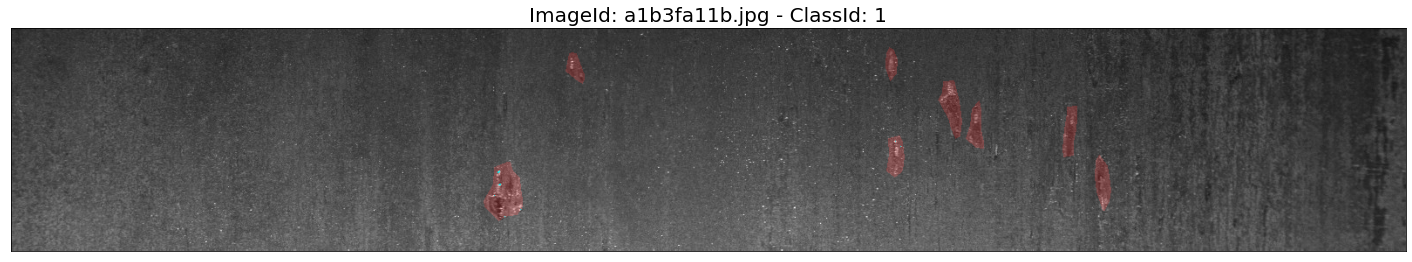

In [ ]:
show_defects(class_id=1, n=1)

The `ClassId = 2` identifies single and multiple defects of grooves.

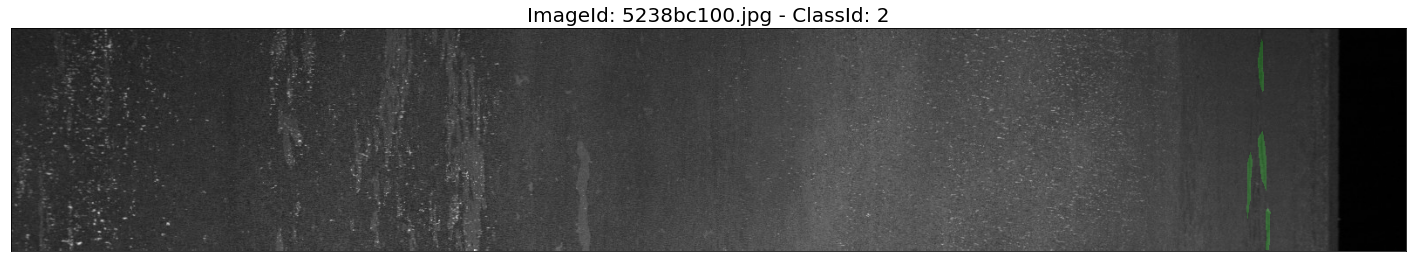

In [ ]:
show_defects(class_id=2, n=1)

The `ClassId = 3` identifies single and multiple defects of scratches.

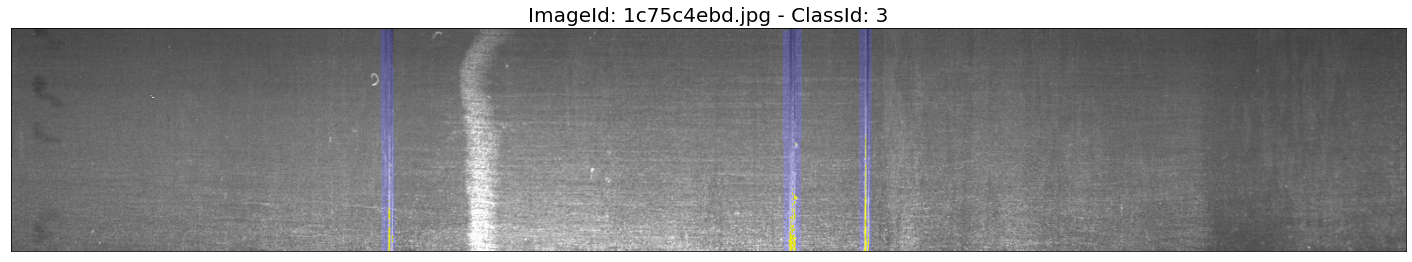

In [ ]:
show_defects(class_id=3, n=1)

The `ClassId = 4` identifies single and multiple defects of rolling process.

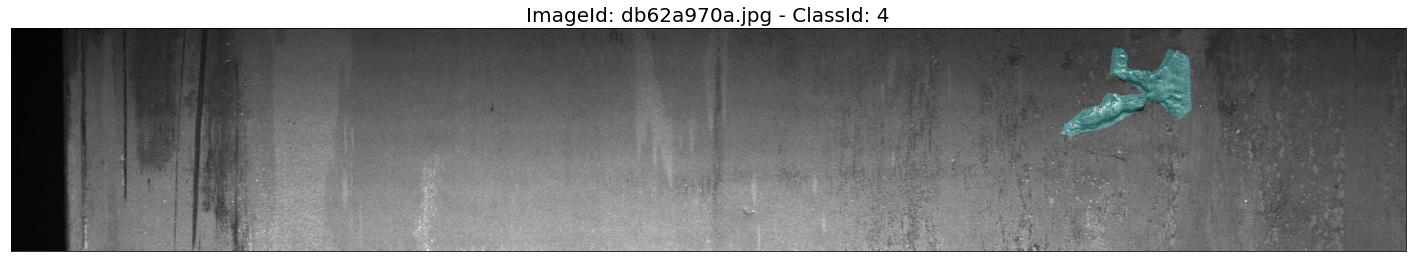

In [ ]:
show_defects(class_id=4, n=1)

To select images with more than one defect:

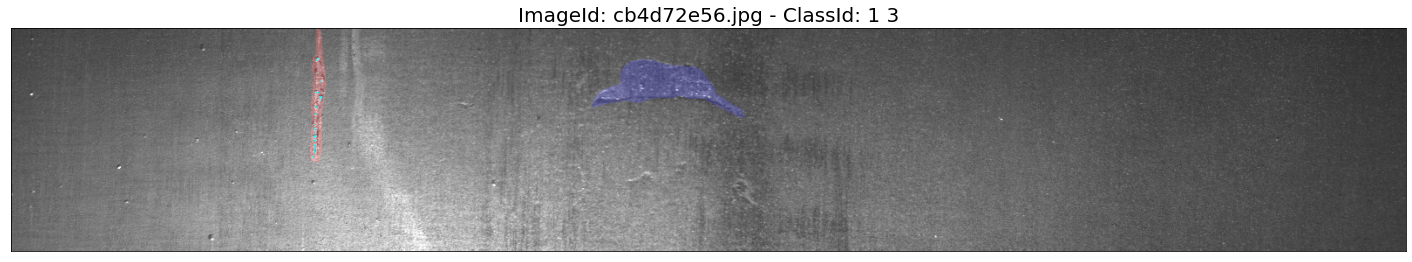

In [ ]:
show_defects(n=1, multi_defects=True)

## RLE functions

In [ ]:
# export
def rle_to_mask(rle: str, class_id: int, height: int, width: int) -> np.ndarray:
    """
    Convert RLE encoded pixels to numpy array for only one class_id
    """
    rows, cols = height, width
    mask = np.zeros(rows*cols, dtype=np.uint8)

    if rle == -1:
        return mask.reshape(cols, rows).T

    encoded_pixels = [int(i) for i in rle.split(" ")]

    # (n, 2) as [[pos, offs], ... ]
    rle_pairs = np.array(encoded_pixels).reshape(-1, 2)

    for index, length in rle_pairs:
        index -= 1
        mask[index: (index + length)] = class_id

    mask = mask.reshape(cols, rows)
    return mask.T

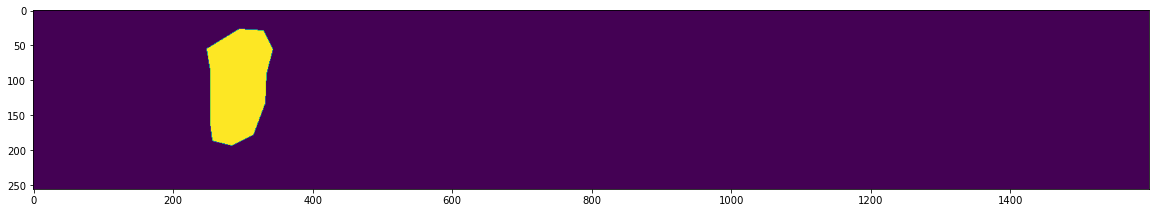

In [ ]:
im = rle_to_mask(tmp_df["EncodedPixels"].iloc[0],
                 tmp_df["ClassId"].iloc[0], height, width)

plt.figure(figsize=(20, 5))
plt.imshow(im)
plt.show()

In [ ]:
# export
def multi_rle_to_mask(img_path: str, df: pd.DataFrame = train_all) -> np.ndarray:
    """
    Convert all RLE encoded pixels for an image and returns the mask
    """
    height, width = 256, 1600

    def build_mask(df) -> np.ndarray:
        masks = defaultdict(np.ndarray)
        for num, row in enumerate(df.itertuples()):
            masks[num] = rle_to_mask(
                row.EncodedPixels, row.ClassId, height, width)

        mask = masks.pop(0)

        items_left = len(masks)
        if items_left:
            for item in range(items_left):
                mask_to_add = masks.get(item + 1)
                mask = np.add(mask, mask_to_add)

        return mask

    img_id = img_path.name
    img_df = df.loc[df["ImageId"] == img_id]
    return build_mask(img_df)

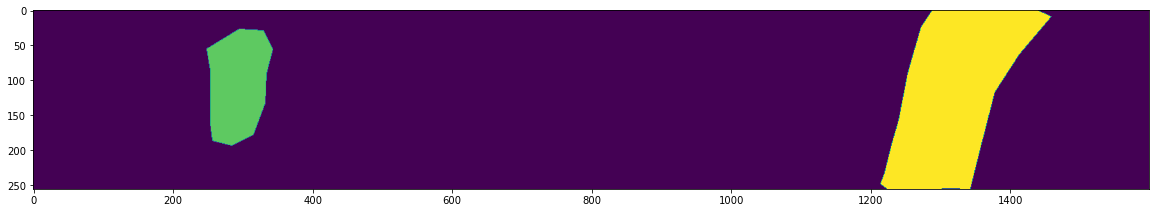

In [ ]:
im = multi_rle_to_mask(img_path)

plt.figure(figsize=(20, 5))
plt.imshow(im)
plt.show()

In [ ]:
# export
def img_with_mask(img_path: str):
    return np.array(Image.open(img_path)), multi_rle_to_mask(img_path)

In [ ]:
img, mask = img_with_mask(img_path)
img.shape, mask.shape, type(img), type(mask)

((256, 1600, 3), (256, 1600), numpy.ndarray, numpy.ndarray)

In [ ]:
# export
def mask2rle(img):
    '''
    From #https://www.kaggle.com/paulorzp/rle-functions-run-lenght-encode-decode

    Attributes: `img`: numpy array, 1 -> mask, 0 -> background.
    
    Returns: run length as string formated
    '''
    pixels= img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

In [ ]:
rle = mask2rle(mask)
rle[:100]

'63800 4 64055 11 64311 17 64566 24 64822 30 65077 114 65332 123 65588 131 65843 137 66099 137 66354 '

In [ ]:
# export
def make_mask(row_id, df=train_pivot):
    '''
    Given a row index, return image_id and mask (256, 1600, 4)
    from the dataframe `df`
    '''
    fname = df.iloc[row_id].name
    labels = df.iloc[row_id][:4]
    
    masks = np.zeros((256, 1600, 4), dtype=np.float32) # float32 is V.Imp
    # 4:class 1～4 (ch:0～3)

    for idx, label in enumerate(labels.values):
        if label is not np.nan:
            label = label.split(" ")
            positions = map(int, label[0::2])
            length = map(int, label[1::2])
            mask = np.zeros(256 * 1600, dtype=np.uint8)
            for pos, le in zip(positions, length):
                mask[pos:(pos + le)] = 1
            masks[:, :, idx] = mask.reshape(256, 1600, order='F')
            
    return fname, masks

In [ ]:
row_id = 0
imgid, mask = make_mask(row_id)
imgid, mask.shape

('0002cc93b.jpg', (256, 1600, 4))

In [ ]:
%timeit make_mask(row_id)

1.28 ms ± 8.87 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [ ]:
test_eq(mask.shape, (256, 1600, 4))
test_eq(im.shape, (256, 1600)) # for fastai

## Labels

To train a segmentation model we need pixel labels for every training image. 

1) As a first approach, I create the masks for all the images in the training folder. The masks are created with `multi_rle_to_mask` so with a `Shape(256, 1600)` and are saved in `labels_path`. 

2) Another approach is to create masks only with defect images and keep a `Shape(256,1600,4)`.

NB: masks must be PNG files and not JPEG because JPEG's compression makes the labels get messed up occasionally ([source](https://forums.fast.ai/t/unet-learner-failing-with-a-cuda-device-assert/66747/4)).

In [ ]:
# export
labels_path = path / "labels"

def create_masks(df: pd.DataFrame):
    """Create the masks for ImageId in df"""
    paths = []
    for img_id in df["ImageId"].tolist():
        img_path = train_path / img_id
        img_label = labels_path/f"{img_path.stem}_P.png"
        if not img_label.is_file():
            mask = multi_rle_to_mask(img_path)
            im = Image.fromarray(mask)
            im.save(img_label)
        paths.append(img_label)
    return L(paths)

In [ ]:
masks = create_masks(train_multi)

In [ ]:
# missing
ntraining = get_image_files(train_path)
test_eq(len(ntraining), len(masks))

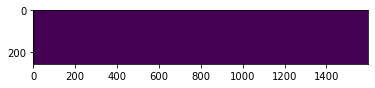

In [ ]:
# missing
idx = get_random_idx(len(masks))
im = np.array(Image.open(masks[idx[0]]))
plt.imshow(im)

In [ ]:
classes=[0,1,2,3,4]
class_ids = np.unique(im).tolist()
check = [c in classes for c in class_ids]
assert False not in check

In [ ]:
# hide
from nbdev.export import notebook2script
notebook2script()

Converted 00_core.ipynb.
Converted 01_data.ipynb.
Converted 02_dataset.ipynb.
Converted 04_model.metrics.ipynb.
Converted 05_models.unet.ipynb.
Converted 06_models.model.ipynb.
Converted index.ipynb.
